# Model Building, Evaluation & Sensitivity Analysis

In this section, we will present a comparative analysis of the heart disease classification problem using different classification algorithms. We use the 80:20 train-test split rule to evaluate our models.
**Note**, a small amount of patients were used as  as hold-out set for hyper-parameter sensitivity analysis. 


## Models
We choose numerous shallow predictive methods to predict heart disease. 
- [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [Gradient Boost Classifier](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Decision Tree Classifier](https://en.wikipedia.org/wiki/Decision_tree_learning)
- [Random Forest Classifier](https://en.wikipedia.org/wiki/Random_forest)
- [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

For more information on these algorithms, please click on the relevant links 

## Evaluation metrics
One of the key requirements in developing any algorithm is to measure it's effectiveness. Accuracy is the most simple measure. It tells us the he number of correctly classified examples over the total number of examples. More formally, 
$$
 Accuracy = \frac{TruePositive + TrueNegative}{TruePositive + TrueNegative + FalsePositive + FalseNegative  }
$$
But is accuracy telling the whole picture ?
Well, let’s consider those two examples:
- A classifier which, if a person has the heart disease, will always correctly diagnose it, but gets half of the healthy people wrong. You can see that announcing to a healthy person that he or she has the disease could lead to adverse consequences.
- A classifier that gets the diagnose right for every healthy person, but also miss half of the disease cases. That wouldn’t be a very good algorithm would it?

Depending on the distribution of sick to healthy patients those two classifiers could have high accuracy while not being considered very good. Therefore, we decide to employ three further metrics
- *Precision:* dertimnes what proportion of the negative class got correctly classified. 
  $$
  \frac{TruePositive}{TruePositive +   FalsePositive    }
  $$
 
- *Recall*: determine what proportion of the actual sick people were correctly detected by the model.
  $$
  \frac{TruePositive}{TruePositive +    FalseNegative   }
  $$


## Import libaries
### Data Processing 

In [2]:
import pandas  as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
warnings.filterwarnings('ignore')

### Model building and evaluation

In [56]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score


from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss
)
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

### Model Serialisation

In [4]:
import pickle

### Data Visualisation

In [5]:
import matplotlib.pyplot as plt

### Code Type Hints

In [19]:
from typing import List


In [6]:

dict_classifiers = {
    "Logistic Regression ": LogisticRegression(),
    "Gradient Boost Classifier": GradientBoostingClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
}

heart_disease_dataset_standardized = pd.read_csv("data/standardised_heart_disease.csv")

# Initial Attempt
train_heart_disease_df = heart_disease_dataset_standardized.drop('HeartDisease',axis='columns')
test_heart_diease_df = heart_disease_dataset_standardized.HeartDisease.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(train_heart_disease_df, test_heart_diease_df, test_size=0.2, random_state=15, stratify=test_heart_diease_df)


In [7]:
print(f"Ratio of classes in training set:\n{y_train.value_counts(normalize=True)}")
print()
print(f"Ratio of classes in test set:\n{y_test.value_counts(normalize=True)}")
      

Ratio of classes in training set:
0.0    0.914406
1.0    0.085594
Name: HeartDisease, dtype: float64

Ratio of classes in test set:
0.0    0.914398
1.0    0.085602
Name: HeartDisease, dtype: float64


We balance the test dataset, to ensure accuracy is a fair measure of model performance.

In [8]:
test_df = X_test.copy()
test_df['HeartDisease'] = y_test
class_0 = test_df[test_df['HeartDisease'] == 0]
class_1 = test_df[test_df['HeartDisease'] == 1]

class_1 = class_1.sample(len(class_0),replace=True)
test_df = pd.concat([class_0, class_1], axis=0)
print('Data in Test:')
print(test_df['HeartDisease'].value_counts())
X_test = test_df.drop('HeartDisease',axis='columns')
y_test = test_df.HeartDisease.astype(np.float32)

Data in Test:
1.0    58484
0.0    58484
Name: HeartDisease, dtype: int64


In [9]:
def run_exps(
             X_train, X_test, y_train, y_test) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: None
    '''
    
    results = pd.DataFrame()
    for model_name, model in dict_classifiers.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        class_report = pd.DataFrame(classification_report(y_test, y_pred, target_names=['No Heart Disease', 'Heart Disease'],output_dict=True)).transpose().reset_index()
        class_report['model'] = [model_name] * class_report.shape[0]
        class_report['auc'] = [roc_auc_score(y_test, y_pred)] * class_report.shape[0]
        class_report = pd.concat([class_report], keys=['Model'], names=['Firstlevel'])
        results = pd.concat([results, class_report], ignore_index=True)
    results['dummy'] = None

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

    for cls, ax in zip(dict_classifiers.values(), axes.flatten()):
        plot_confusion_matrix(cls, 
                            X_test, 
                            y_test, 
                            ax=ax, 
                            cmap='Blues',
                            display_labels=['No Heart Disease', 'Heart Disease'])
        ax.title.set_text(type(cls).__name__)
    plt.tight_layout()  
    plt.show()

    print(f"""Algorithm with the highest accuracy: {
        results[results['index'] == 'accuracy'].sort_values(
            ['support'], ascending=False).head(1)[['model', 'support']].values[0].tolist()}""")
    
    print(f"""Algorithm with the highest macro recall:
        {results[results['index'] == 'macro avg'].sort_values(
            ['recall'], ascending=False).head(1)[['model', 'recall']].values[0].tolist()}""")
    
    print(f"""Algorithm with the highest macro precision:
        {results[results['index'] == 'macro avg'].sort_values(
            ['precision'], ascending=False).head(1)[['model', 'precision']].values[0].tolist()}""")
    
    print(f"""Algorithm with the highest AUC:
        {results.sort_values(['auc'], ascending=False).head(1)[
            ['model', 'auc']].values[0].tolist()}""")
    
    print(results.groupby(
        ['model', 'index', 'precision', 'recall', 'f1-score', 'support',  'auc']
        )['dummy'].count())
    
    return results

## Imbalanced data
As you can see above, our data is extremely imbalanced. Imbalanced datasets are those where there is a severe skew in the class distribution, such as 1:100 or 1:1000 examples in the minority class to the majority class.

This bias in the training dataset can influence many machine learning algorithms, leading some to ignore the minority class entirely. This is a problem as it is typically the minority class on which predictions are most important (i.e. predicting heart disease in our case).

One approach to addressing the problem of class imbalance is to randomly resample the training dataset. The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling.



## Undersampling 



The follwoing undersampling methods were choosen:
- `RandomUnderSampler`: Random undersampling consists in extracting at random samples from the majority class, until they reach a certain proportion compared to the minority class, typically 50:50.
- `CondensedNearestNeighbour`: The algorithms works as follows:
    - Put all minority class observations in a group, typically group O
    - Add 1 sample (at random) from the majority class to group O
    - Train a KNN with group O
    - Take a sample of the majority class that is not in group O yet
    - Predict its class with the KNN from point 3
    - If the prediction was correct, go to 4 and repeat
    - If the prediction was incorrect, add that sample to group O, go to 3 and repeat
    - Continue until all samples of the majority class were either assigned to O or left out
    - Final version of Group O is our undersampled dataset

    This algorithm tends to pick points near the fuzzy boundary between the classes, and transfer those to the group O, in our example. If the classes are similar, group O will contain a fair amount of both classes. If the classes are very different, group O would contain mostly 1 class, the minority class.
- `TomekLinks`: Tomek links are 2 samples from a different class, which are nearest neighbours to each other. In other words, if 2 observations are nearest neighbours, and from a different class, they are Tomek Links. This procedures removes either the sample from the majority class if it is a Tomek Link, or alternatively, both observations, the one from the majority and the one from the minority class.
- `OneSidedSelection`: First finds the hardest instances to classify correctly from the majority class. Then removes noisy observations with Tomek Links.
- `EditedNearestNeighbours`: Train a KNN algorithm on the data (user defines number of neighbours, typically 3)
  - Find the 3 nearest neighbour to each observation (or the number defined by the user in 1)
  - Find the label of each of the neighbours (we know it, is the target in the dataset)
  - if the majority of the neighbours show the same label as the observation, then we keep the observation
  
- `RepeatedEditedNearestNeighbours`: Extends Edited Nearest neighbours in that it repeats the procedure over an over, until no further observation is removed from the dataset, or alternatively until a maximum number of iterations is reached.
- `AllKNN`: Adapts the functionality of Edited Nearest Neighbours in that, at each round, it increases the number of neighbours utilised to exclude or retain the observations.
          It starts by looking at the 1 closest neighbour.
          It finishes at a maximum number of neighbours to examine, determined by the user
          it stops prematurely if the majority class becomes the minority
- `NeighbourhoodCleaningRule`: The Neighbourhood Cleaning Rule works as follows:
    1) Remove noisy observations from the majority class with ENN:
    - explores the 3 closest neighbours\n
    - uses majority vote of neighbours to retain observations
    2) Remove observations from the majority class if:,
    - they are 1 of the 3 closest neighbours to a minority sample, and,
    - most / all of those 3 closest neighbours are not minority, and,
    - the majority class has at least half as many observations as those in the minority (this can be regulated)
- `NearMiss`: This procedures aims to select samples that are somewhat similar to the minority class, using 1 of three alternative procedures:
  - Select observations closer to the closest minority class
  - Select observations closer to the farthest minority class
  - Select observations furthest from their nearest neighbours


:::{note}
We train the models on a portion of the data that is under-sampled
We evaluate the model performance on another portion of the data that was not resampled, and thus contains the original class distribution.
:::

:::{note}
In addition a verbose output of the models performance will be generated. 
:::

In [44]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    # 'cnn': CondensedNearestNeighbour(
    #     sampling_strategy='auto',
    #     random_state=0,
    #     n_neighbors=1,
    #     n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    # 'enn': EditedNearestNeighbours(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=4),

    # 'renn': RepeatedEditedNearestNeighbours(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=4,
    #     max_iter=100),

    # 'allknn': AllKNN(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=4),

    # 'ncr': NeighbourhoodCleaningRule(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=4,
    #     threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),
}

No UnderSampling
-------------------


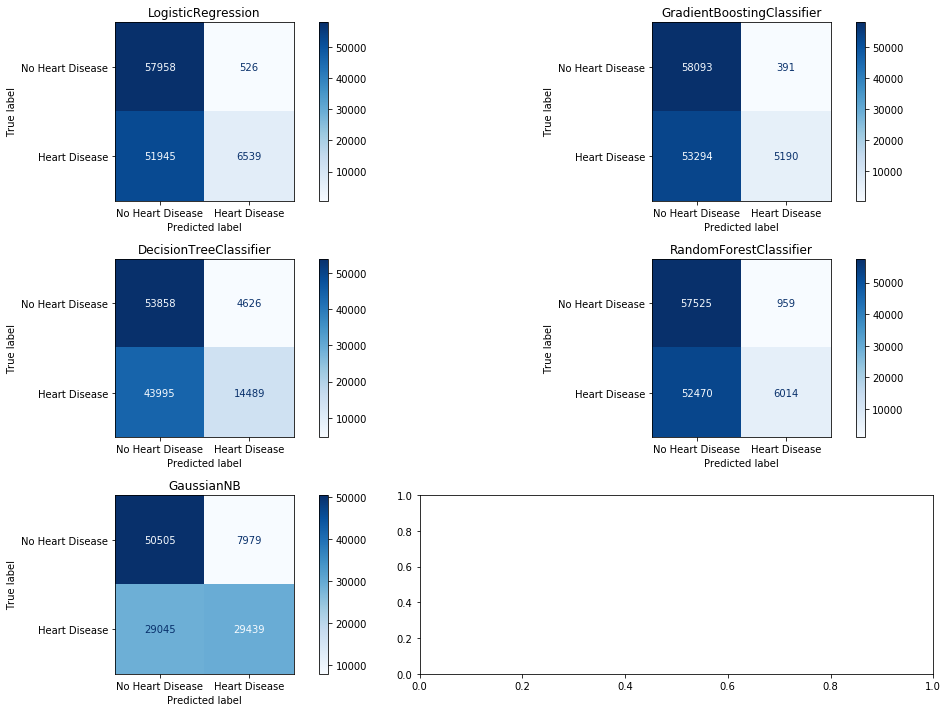

Algorithm with the highest accuracy: ['Naive Bayes', 0.6834689829697012]
Algorithm with the highest macro recall:
        ['Naive Bayes', 0.6834689829697012]
Algorithm with the highest macro precision:
        ['Logistic Regression ', 0.7264522097814119]
Algorithm with the highest AUC:
        ['Naive Bayes', 0.683468982969701]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.757991   0.247743  0.373433  58484.000000   0.584322    0
                           No Heart Disease  0.550397   0.920901  0.688999  58484.000000   0.584322    0
                           accuracy          0.584322   0.584322  0.584322  0.584322       0.584322    0
                           macro avg         0.654194   0.584322  0.531216  116968.000000  0.584322    0
                           weighted avg      0.654194   0.584322  0.531216  116968.000000  0.584322    0
Gradient Boost Classifier  Heart Disease     

NameError: name 'undersampler_dict' is not defined

In [13]:
# train a model on the original data without under-sampling
# and determine model performance
print("No UnderSampling")
print("-------------------")
run_exps(X_train, X_test, y_train, y_test)

print("UnderSampling Methods")
print("-------------------")
print()

# now, we test the different under-samplers, 1 at a time
for undersampler in undersampler_dict.keys():
    
    print(undersampler)
    print("-------------------")
    
    # resample the train set only
    X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train.copy(), y_train.copy())
    
    # train model and evaluate performance
    
    # Note the performance returned is using the
    # test set, which was not under-sampled
    
    run_exps(X_resampled, X_test, y_resampled, y_test)
    
    print()
    
print()

As we can see in the verbose model output,our best setting occurred with the `Random` undersampling strategy. Across most tracked metrics, we see a significant improvement in model performance compared with no undersupplying techniques. 


**Base** (no under sampling techniques) **winners** for tracked metrics:

| Metric     | Metric   | Value       
|---------------|-----------|:----------------:|
|   Accuracy          |  Naive Bayes          | 0.684  |
|   Macro Recall          |  Naive Bayes          | 0.684  |
|   Macro precision          |  Gradient Boost Classifier         | 0.726  |
|   AUC       |  Naive Bayes          | 0.684  |

**Random under sampling technique winners** for tracked metrics:
| Metric     | Metric   | Value       
|---------------|-----------|:----------------:|
|   Accuracy          |  Gradient Boost Classifier          | 0.764  |
|   Macro Recall          |  Gradient Boost Classifier          | 0.763  |
|   Macro precision          |  Gradient Boost Classifier         | 0.765  |
|   AUC       |  Gradient Boost Classifier          | 0.763  |



## Oversampling

The following undersampling methods were choosen:
- `Random Oversampling:` Random over-sampling consists in extracting at random samples from the minority class, until they reach a certain proportion compared to the majority class, typically 50:50, or in other words, a balancing ratio of 1.
- `SMOTE`: Creates new samples by interpolation of samples of the minority class and any of its k nearest neighbours (also from the minority class). K is typically 5.
- `ADASYN`: Creates new samples by interpolation of samples of the minority class and its closest neighbours. It creates more samples from samples that are harder to classify.
- `Borderline SMOTE`: Creates new samples by interpolation between samples of the minority class and their closest neighbours.
  - It does not use all observations from the minority class as templates, unllike SMOTE.
  - It selects those observations (from the minority) for which, most of their neighbours belong to a different class (DANGER group)
    - Variant 1 creates new examples, as SMOTE, between samples in the Danger group and their closest neighbours from the minority
    - Variant 2 creates new examples between samples in the Danger group and neighbours from minority and majority class
- `SVM SMOTE`: Creates new samples by interpolation of samples of the support vectors from minority class and its closest neighbours.




:::{note}
We train the models on a portion of the data that is over-sampled
We evaluate the model performance on another portion of the data that was not resampled, and thus contains the original class distribution.
:::

In [10]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),

    'smote': SMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        n_jobs=4),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        n_jobs=4),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=4),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        n_jobs=4),

    # 'svm': SVMSMOTE(
    #     sampling_strategy='auto',  # samples only the minority class
    #     random_state=0,  # for reproducibility
    #     k_neighbors=5,
    #     m_neighbors=10,
    #     n_jobs=4,
    #     svm_estimator=SVC(kernel='linear')),
}

No OverSampling
-------------------


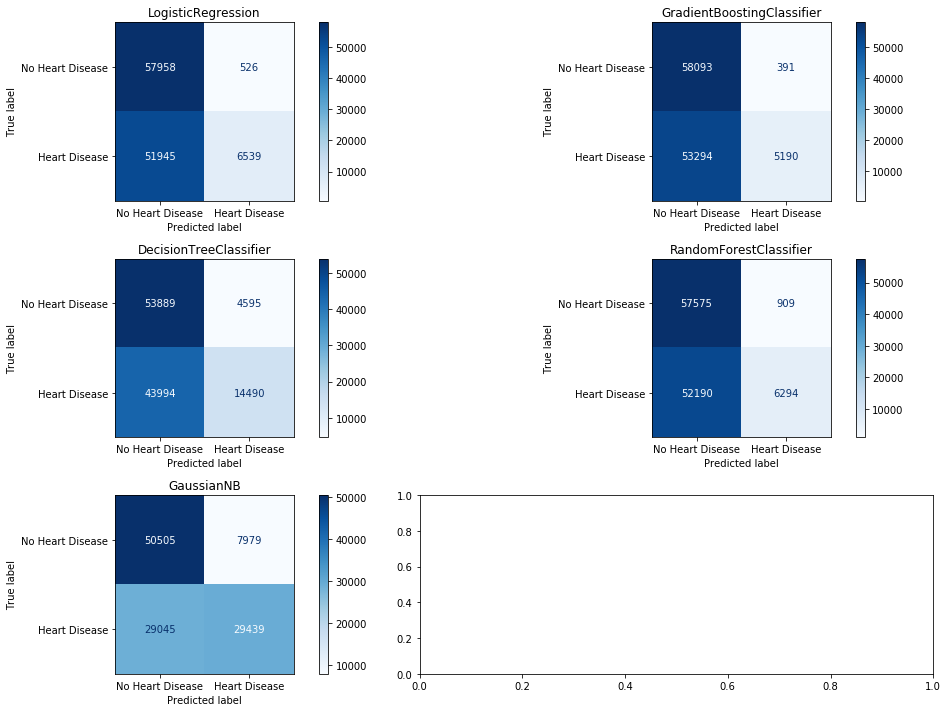

Algorithm with the highest accuracy: ['Naive Bayes', 0.6834689829697012]
Algorithm with the highest macro recall:
        ['Naive Bayes', 0.6834689829697012]
Algorithm with the highest macro precision:
        ['Logistic Regression ', 0.7264522097814119]
Algorithm with the highest AUC:
        ['Naive Bayes', 0.683468982969701]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.759235   0.247760  0.373603  58484.000000   0.584596    0
                           No Heart Disease  0.550545   0.921432  0.689263  58484.000000   0.584596    0
                           accuracy          0.584596   0.584596  0.584596  0.584596       0.584596    0
                           macro avg         0.654890   0.584596  0.531433  116968.000000  0.584596    0
                           weighted avg      0.654890   0.584596  0.531433  116968.000000  0.584596    0
Gradient Boost Classifier  Heart Disease     

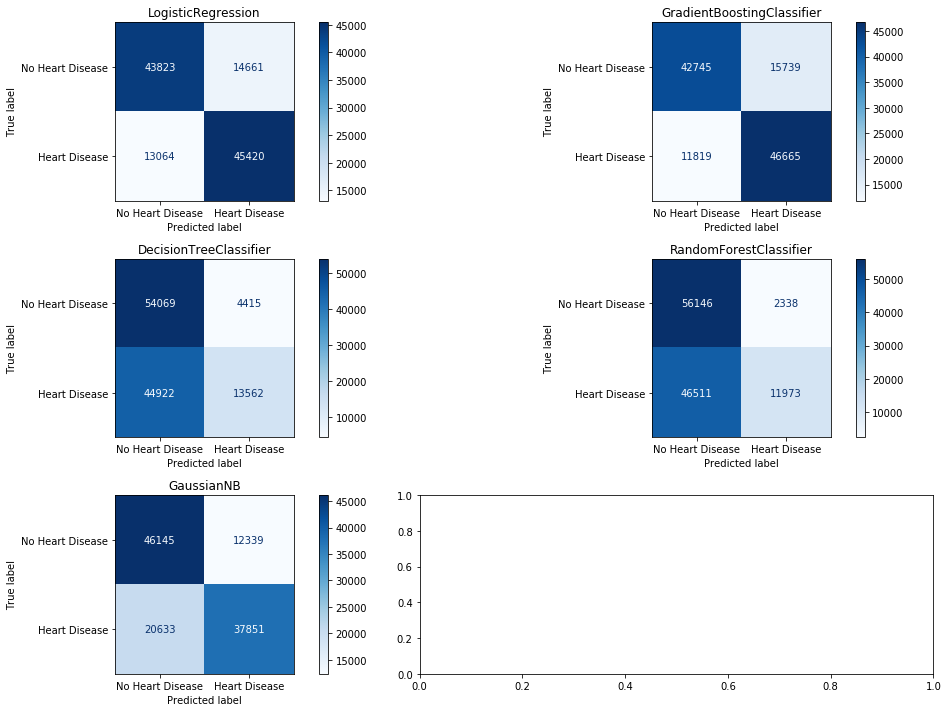

Algorithm with the highest accuracy: ['Gradient Boost Classifier', 0.7643971000615553]
Algorithm with the highest macro recall:
        ['Gradient Boost Classifier', 0.7643971000615553]
Algorithm with the highest macro precision:
        ['Gradient Boost Classifier', 0.7655902916773867]
Algorithm with the highest AUC:
        ['Gradient Boost Classifier', 0.7643971000615553]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.754408   0.231892  0.354743  58484.000000   0.578201    0
                           No Heart Disease  0.546201   0.924509  0.686699  58484.000000   0.578201    0
                           accuracy          0.578201   0.578201  0.578201  0.578201       0.578201    0
                           macro avg         0.650305   0.578201  0.520721  116968.000000  0.578201    0
                           weighted avg      0.650305   0.578201  0.520721  116968.000000  0.578201   

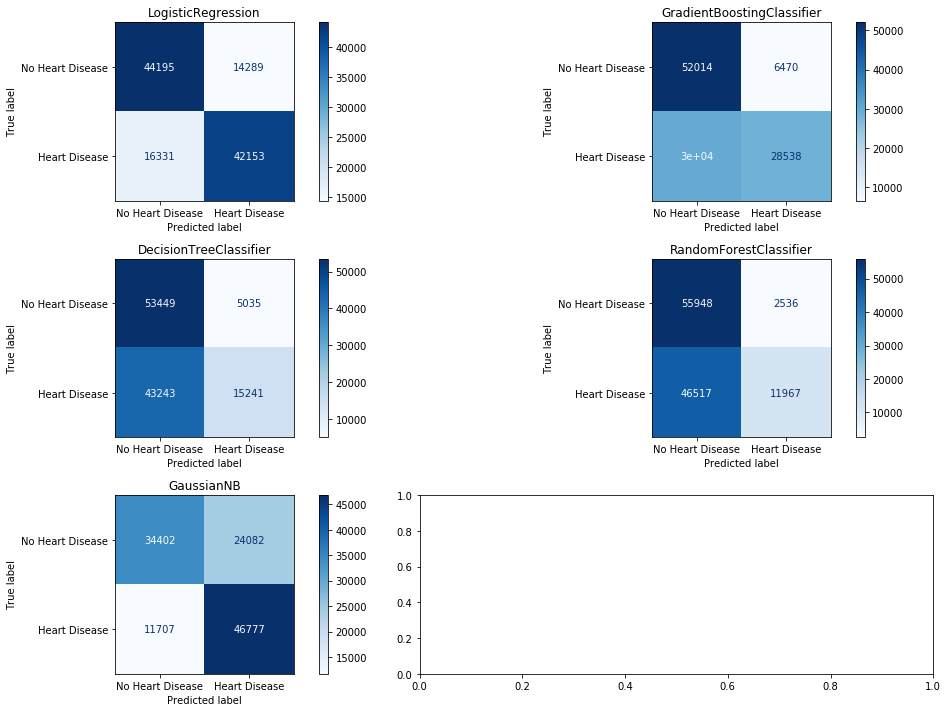

Algorithm with the highest accuracy: ['Logistic Regression ', 0.7382190000683948]
Algorithm with the highest macro recall:
        ['Logistic Regression ', 0.7382190000683948]
Algorithm with the highest macro precision:
        ['Logistic Regression ', 0.7385097659900086]
Algorithm with the highest AUC:
        ['Logistic Regression ', 0.7382190000683948]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.751677   0.260601  0.387024  58484.000000   0.587255    0
                           No Heart Disease  0.552776   0.913908  0.688882  58484.000000   0.587255    0
                           accuracy          0.587255   0.587255  0.587255  0.587255       0.587255    0
                           macro avg         0.652226   0.587255  0.537953  116968.000000  0.587255    0
                           weighted avg      0.652226   0.587255  0.537953  116968.000000  0.587255    0
Gradient Boost Cl

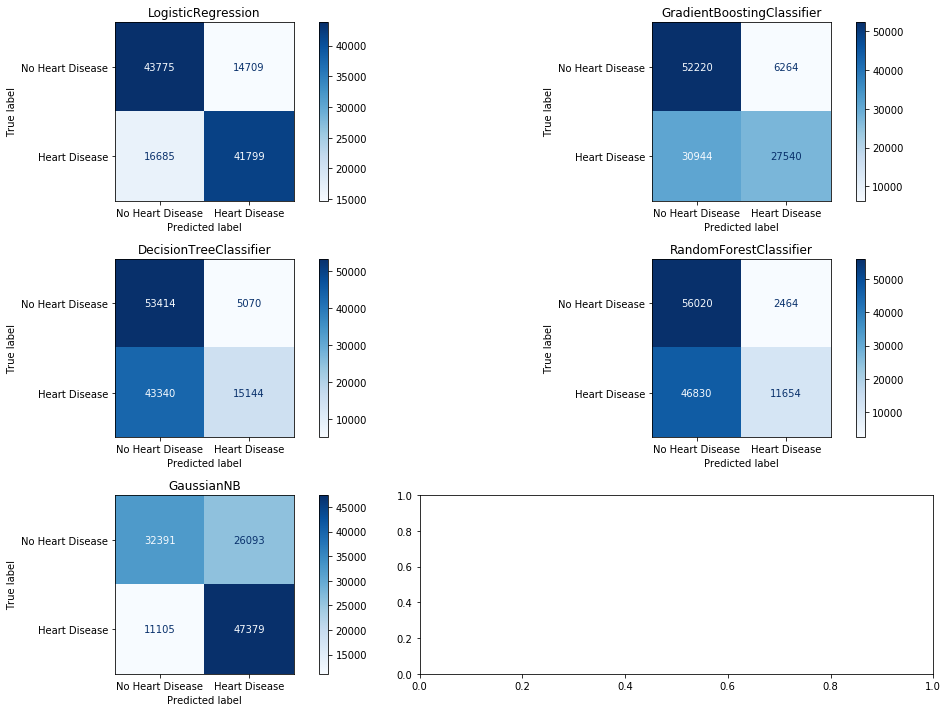

Algorithm with the highest accuracy: ['Logistic Regression ', 0.7316018056220505]
Algorithm with the highest macro recall:
        ['Logistic Regression ', 0.7316018056220505]
Algorithm with the highest macro precision:
        ['Logistic Regression ', 0.7318664957489149]
Algorithm with the highest AUC:
        ['Logistic Regression ', 0.7316018056220505]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.749184   0.258943  0.384864  58484.000000   0.586126    0
                           No Heart Disease  0.552060   0.913310  0.688156  58484.000000   0.586126    0
                           accuracy          0.586126   0.586126  0.586126  0.586126       0.586126    0
                           macro avg         0.650622   0.586126  0.536510  116968.000000  0.586126    0
                           weighted avg      0.650622   0.586126  0.536510  116968.000000  0.586126    0
Gradient Boost Cl

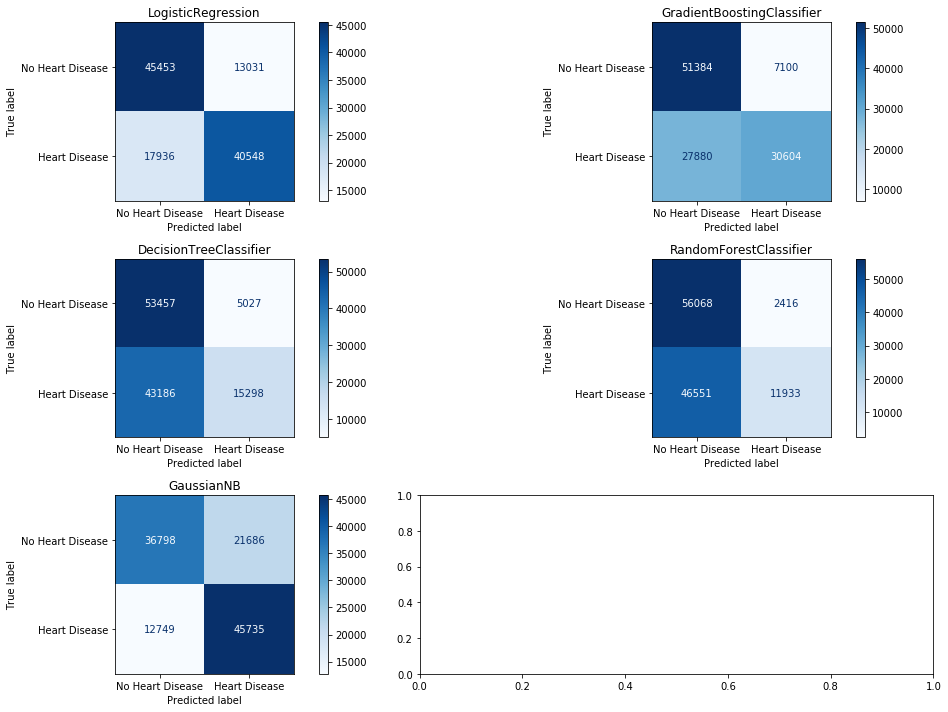

Algorithm with the highest accuracy: ['Logistic Regression ', 0.7352523767184187]
Algorithm with the highest macro recall:
        ['Logistic Regression ', 0.7352523767184187]
Algorithm with the highest macro precision:
        ['Logistic Regression ', 0.7369188698917095]
Algorithm with the highest AUC:
        ['Logistic Regression ', 0.7352523767184187]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.752669   0.261576  0.388230  58484.000000   0.587810    0
                           No Heart Disease  0.553139   0.914045  0.689203  58484.000000   0.587810    0
                           accuracy          0.587810   0.587810  0.587810  0.587810       0.587810    0
                           macro avg         0.652904   0.587810  0.538716  116968.000000  0.587810    0
                           weighted avg      0.652904   0.587810  0.538716  116968.000000  0.587810    0
Gradient Boost Cl

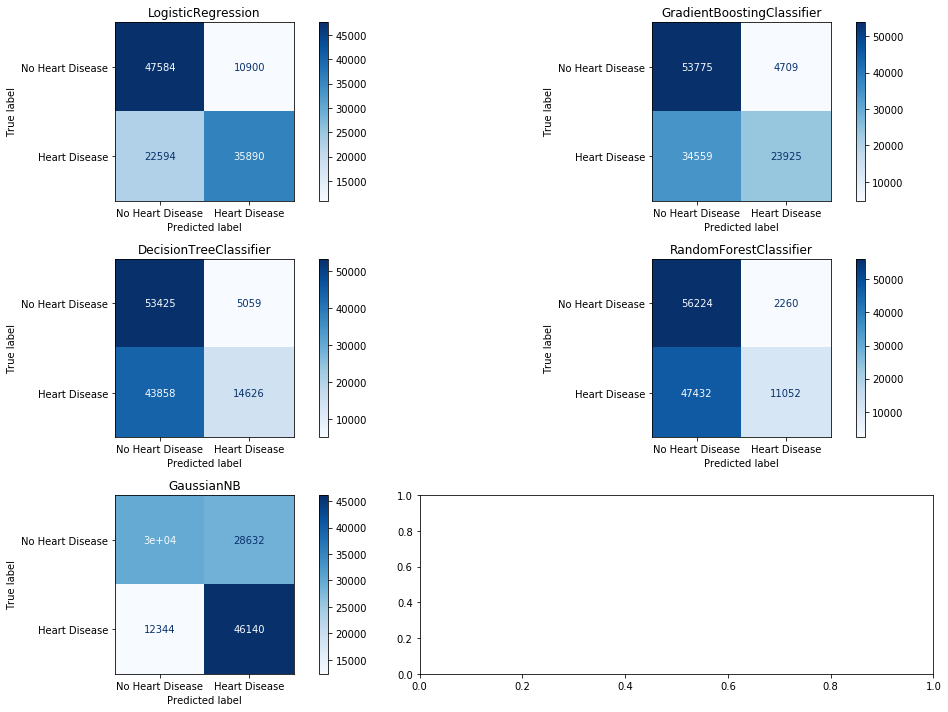

Algorithm with the highest accuracy: ['Logistic Regression ', 0.7136481772792559]
Algorithm with the highest macro recall:
        ['Logistic Regression ', 0.7136481772792558]
Algorithm with the highest macro precision:
        ['Logistic Regression ', 0.7225457457487992]
Algorithm with the highest AUC:
        ['Logistic Regression ', 0.7136481772792559]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.743002   0.250085  0.374215  58484.000000   0.581792    0
                           No Heart Disease  0.549171   0.913498  0.685960  58484.000000   0.581792    0
                           accuracy          0.581792   0.581792  0.581792  0.581792       0.581792    0
                           macro avg         0.646087   0.581792  0.530088  116968.000000  0.581792    0
                           weighted avg      0.646087   0.581792  0.530088  116968.000000  0.581792    0
Gradient Boost Cl

In [12]:
# train a model on the original data without under-sampling
# and determine model performance
print("No OverSampling")
print("-------------------")
run_exps(X_train, X_test, y_train, y_test)

print()

print("OverSampling Methods")
print("-------------------")

# now, we test the different under-samplers, 1 at a time
for oversampler in oversampler_dict.keys():
    
    print(oversampler)
    print("-------------------")
    
    # resample the train set only
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train.copy(), y_train.copy())
    
    # train model and evaluate performance
    
    # Note the performance returned is using the
    # test set, which was not under-sampled
    
    run_exps(X_resampled, X_test, y_resampled, y_test)
    
    print()
    
print()

As we can see in the verbose model output,our best setting occurred with the `Random` over sampling strategy. Across most tracked metrics, we see a significant improvement in model performance compared with no oversampling techniques. 


**Base** (no under sampling techniques) **winners** for tracked metrics:

| Metric     | Metric   | Value       
|---------------|-----------|:----------------:|
|   Accuracy          |  Naive Bayes          | 0.684  |
|   Macro Recall          |  Naive Bayes          | 0.684  |
|   Macro precision          |  Gradient Boost Classifier         | 0.726  |
|   AUC       |  Naive Bayes          | 0.684  |

**Random over sampling technique winners** for tracked metrics:
| Metric     | Metric   | Value       
|---------------|-----------|:----------------:|
|   Accuracy          |  Gradient Boost Classifier          | 0.764  |
|   Macro Recall          |  Gradient Boost Classifier          | 0.764  |
|   Macro precision          |  Gradient Boost Classifier         | 0.765  |
|   AUC       |  Gradient Boost Classifier          | 0.764  |



From now on, we choose the Gradient Boost Classifier with random oversampling as our base model. We will now try to improve the performance of the model by using the feature selection. Although random undersampling achieves similar accuracy as random oversampling, we achieve marginally better auc, precision and recall scores. 

## Feature Selection
 The idea of feature selection and extraction is to avoid the curse of
dimensionality. This refers to the fact that as we move to higher
dimension input feature spaces the volume of the space grows rapidly
and we end up with very few instances per unit volume, i.e. we have
very sparse sampling of the space of possible instances making
modelling difficult.

Feature Selection: It is clear from what we have seen that a good feature engineering
idea might be to choose a subset of the features available to reduce
the dimension of the feature space. This act is called feature
selection. One way of doing this is to try out different permutations of
features increasing the numbers of features involved as you proceed
and calculate machine learning performance. This is rarely practical
though. More efficient approaches include wrapper, filter and
embedded methods.

We decide to explore the following methods:
- Perform PCA anaylsis and idenitify the variables that most contribute to the 
- A simple filter method:
  - Identify input features having high correlation with target variable.
  - Identify input features that have a low correlation with other independent variables
  - Find the information gain or mutual information of the independent variable with respect to a target variable

### PCA



PCA is mathematically defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

We decide to get the top 5 features that contribute most to the first principal component and the top 5 features that contribute most to the second principal compoenent.

In [20]:
def pca_most_important_features(df: pd.DataFrame) -> List[str]:
    """
    Retrieve the top 10 features that contribute most 
        variation to the top 2 principal components
    """
    model = PCA(n_components=2).fit(df)

    # number of components
    n_pcs: int = model.components_.shape[0]

    most_important_features_indicies: List[int] = []
    for i in range(n_pcs):
        top_5 = np.argpartition(np.abs(model.components_[i]), -5)[-5:].tolist()
        most_important_features_indicies.extend(top_5)
        
    most_important_features_indicies = list(set(most_important_features_indicies))
    initial_feature_names = df.columns
    most_important_names  = [initial_feature_names[i] for i in most_important_features_indicies]
    
    return most_important_names
    

In [26]:
pca_features = pca_most_important_features(heart_disease_dataset_standardized)
pca_features

['BMI',
 'PhysicalHealth',
 'MentalHealth',
 'AgeCategory',
 'GenHealth',
 'SleepTime',
 'BMI_Bin',
 'LOG_BMI']

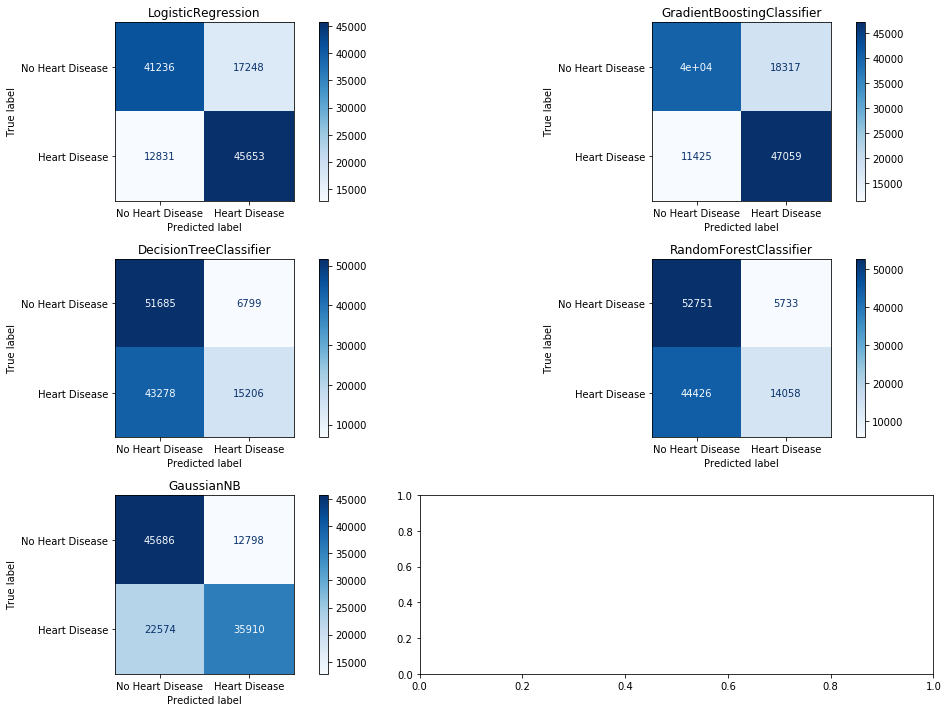

Algorithm with the highest accuracy: ['Gradient Boost Classifier', 0.7457253265850489]
Algorithm with the highest macro recall:
        ['Gradient Boost Classifier', 0.7457253265850489]
Algorithm with the highest macro precision:
        ['Gradient Boost Classifier', 0.7491858337247853]
Algorithm with the highest AUC:
        ['Gradient Boost Classifier', 0.7457253265850489]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.691025   0.260003  0.377840  58484.000000   0.571874    0
                           No Heart Disease  0.544265   0.883746  0.673653  58484.000000   0.571874    0
                           accuracy          0.571874   0.571874  0.571874  0.571874       0.571874    0
                           macro avg         0.617645   0.571874  0.525747  116968.000000  0.571874    0
                           weighted avg      0.617645   0.571874  0.525747  116968.000000  0.571874   

,index,precision,recall,f1-score,support,model,auc,dummy
0,No Heart Disease,0.762683,0.705082,0.732752,58484.000000,Logistic Regression,0.742844,None
1,Heart Disease,0.725791,0.780607,0.752202,58484.000000,Logistic Regression,0.742844,None
2,accuracy,0.742844,0.742844,0.742844,0.742844,Logistic Regression,0.742844,None
3,macro avg,0.744237,0.742844,0.742477,116968.000000,Logistic Regression,0.742844,None
4,weighted avg,0.744237,0.742844,0.742477,116968.000000,Logistic Regression,0.742844,None
5,No Heart Disease,0.778551,0.686803,0.729805,58484.000000,Gradient Boost Classifier,0.745725,None
6,Heart Disease,0.719821,0.804647,0.759874,58484.000000,Gradient Boost Classifier,0.745725,None
7,accuracy,0.745725,0.745725,0.745725,0.745725,Gradient Boost Classifier,0.745725,None
8,macro avg,0.749186,0.745725,0.744839,116968.000000,Gradient Boost Classifier,0.745725,None
9,weighted avg,0.749186,0.745725,0.744839,116968.000000,Gradient Boost Classifier,0.745725,None


In [29]:
X_resampled, y_resampled = oversampler_dict['random'].fit_resample(X_train.copy(), y_train.copy())
run_exps(X_resampled[pca_features], X_test[pca_features], y_resampled, y_test)
    


We note a marginal decrease in model performance when using the top 5 features from the 2 principal components. This is likely due to the fact that the top 5 features from the 2 principal components are not the most important features in the dataset.

### Filter Methods

A simple filter method:
  - `Identify input features having high correlation with target variable`: We want to keep features with only a high correlation with the target variable. This implies that the input feature has a high influence in predicting the target variable. We set the threshold to the absolute value of 0.2. We keep input features only if the correlation of the input feature with the target variable is greater than 0.2. Our analysis reveled most variables have little if all correlation to our target variable

  - `Find the information gain or mutual information of the independent variable with respect to a target variable`

In [30]:
def idenity_high_corr_features(df: pd.DataFrame) -> List[str]:
    importances = df.drop(
        "HeartDisease", axis=1).apply(
            lambda x: x.corr(df.HeartDisease))
    
    indices = np.argsort(importances)
    important_feature_names = []
    for i in range(0, len(indices)):
        if np.abs(importances[i]) > 0.2:
            important_feature_names.append(
                df.columns[i])
    return important_feature_names
    

In [31]:
high_corr_features = idenity_high_corr_features(heart_disease_dataset_standardized)
high_corr_features

['MentalHealth', 'DiffWalking', 'PhysicalActivity']

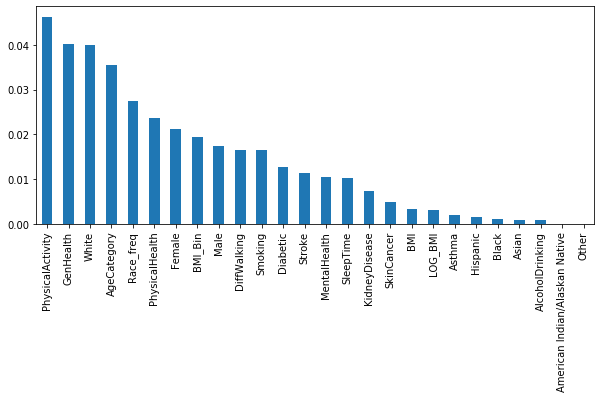

In [32]:
mi = mutual_info_classif(heart_disease_dataset_standardized.drop("HeartDisease", axis=1),
                         heart_disease_dataset_standardized["HeartDisease"])
mi = pd.Series(mi)
mi.index = heart_disease_dataset_standardized.drop("HeartDisease", axis=1).columns
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))


In [50]:
top_10_mi = mi.sort_values(ascending=False)[:10].index.tolist()
top_10_mi

['PhysicalActivity',
 'GenHealth',
 'White',
 'AgeCategory',
 'Race_freq',
 'PhysicalHealth',
 'Female',
 'BMI_Bin',
 'Male',
 'DiffWalking']

We choose to pick the top 10 features, ranked by mutual information, along with the high correlation features to use in our model.

In [53]:
filter_features = list(set(top_10_mi) | (set(high_corr_features)))
filter_features

['Male',
 'GenHealth',
 'BMI_Bin',
 'PhysicalActivity',
 'Race_freq',
 'PhysicalHealth',
 'Female',
 'White',
 'DiffWalking',
 'AgeCategory',
 'MentalHealth']

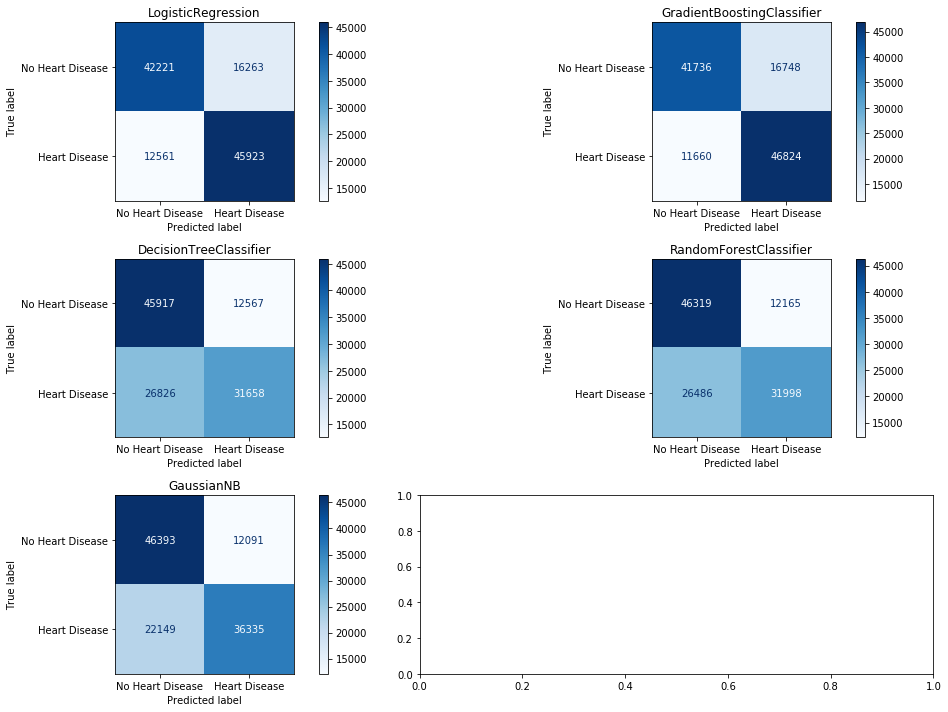

Algorithm with the highest accuracy: ['Gradient Boost Classifier', 0.7571301552561385]
Algorithm with the highest macro recall:
        ['Gradient Boost Classifier', 0.7571301552561385]
Algorithm with the highest macro precision:
        ['Gradient Boost Classifier', 0.7590911327902984]
Algorithm with the highest AUC:
        ['Gradient Boost Classifier', 0.7571301552561385]
model                      index             precision  recall    f1-score  support        auc     
Decision Tree Classifier   Heart Disease     0.715839   0.541310  0.616460  58484.000000   0.663216    0
                           No Heart Disease  0.631222   0.785121  0.699810  58484.000000   0.663216    0
                           accuracy          0.663216   0.663216  0.663216  0.663216       0.663216    0
                           macro avg         0.673531   0.663216  0.658135  116968.000000  0.663216    0
                           weighted avg      0.673531   0.663216  0.658135  116968.000000  0.663216   

,index,precision,recall,f1-score,support,model,auc,dummy
0,No Heart Disease,0.770709,0.721924,0.745519,58484.000000,Logistic Regression,0.753574,None
1,Heart Disease,0.738478,0.785223,0.761134,58484.000000,Logistic Regression,0.753574,None
2,accuracy,0.753574,0.753574,0.753574,0.753574,Logistic Regression,0.753574,None
3,macro avg,0.754594,0.753574,0.753327,116968.000000,Logistic Regression,0.753574,None
4,weighted avg,0.754594,0.753574,0.753327,116968.000000,Logistic Regression,0.753574,None
5,No Heart Disease,0.781632,0.713631,0.746085,58484.000000,Gradient Boost Classifier,0.757130,None
6,Heart Disease,0.736551,0.800629,0.767254,58484.000000,Gradient Boost Classifier,0.757130,None
7,accuracy,0.757130,0.757130,0.757130,0.757130,Gradient Boost Classifier,0.757130,None
8,macro avg,0.759091,0.757130,0.756670,116968.000000,Gradient Boost Classifier,0.757130,None
9,weighted avg,0.759091,0.757130,0.756670,116968.000000,Gradient Boost Classifier,0.757130,None


In [54]:
X_resampled, y_resampled = oversampler_dict['random'].fit_resample(X_train.copy(), y_train.copy())
run_exps(X_resampled[filter_features], X_test[filter_features], y_resampled, y_test)

Our filter method results in a marginal decrease in the evaluation metrics tracked when compared to with just the oversampling method applied. Although, we do achieve a slight increase in the all scores when compared to our PCA analysis method.

## Hyperparameter finetuning
Our best setting was the gradient booting classifier method with the random oversampling method applied. We will now try to improve the performance of the model by finetuning the hyperparameters of the model. We use cross validation on the trainig data to fine tune our model, focusing on the accuracy metric.

In [59]:
X_resampled, y_resampled = oversampler_dict['random'].fit_resample(X_train.copy(), y_train.copy())

In [60]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}
cv = GridSearchCV(gbc,parameters,cv=5, scoring='accuracy')
cv.fit(X_resampled,y_resampled)

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
display(cv)

## Pickle Model
Pickle is the standard way of serializing objects in Python.

You can use the pickle operation to serialize your machine learning algorithms and save the serialized format to a file.

Later we will load this file to deserialize your model and use it to make new predictions in our web app.

In [ ]:
model  =  GradientBoostingClassifier()

In [ ]:
model.fit(X_resampled, y_resampled)

GaussianNB()

In [ ]:
pickle.dump(model, open('../app/model/finalized_model.sav', 'wb'))